In [52]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import env
from env import user, password, host
from scipy import stats
#from acquire import get_zillow
from prepare import clean_zillow_dataset, get_zillow
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
# math module for square root
from math import sqrt
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SequentialFeatureSelector

#from evaluate import select_kbest_feature_engineering, rfe_feature_engineering
#from evaluate import scaled_data, assessed_value_regression_plot, baseline_vs_model_regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

In [2]:

df = get_zillow()
df = clean_zillow_dataset(df)
df.head()

,bedroom_count,bath_count,finished_sq_feet,year_built,fips,home_value
0,2,1.0,1412.0,1947,6037,222671.0
1,3,2.0,1296.0,1955,6037,64968.0
2,3,1.0,1044.0,1947,6037,126800.0
3,3,2.0,1336.0,1955,6037,213833.0
4,3,2.0,1510.0,1979,6037,338022.0


In [3]:
#df.to_csv("/Users/luisarce/codeup-data-science/Regression_Project/regression_zillow.csv")

In [4]:
# Check shape of import
df.shape

(55735, 6)

In [5]:
# cleaning for outliers
def zillow_outliers(df):
    df = df[df["bath_count"] <= 6]
    df = df[df["bedroom_count"] <= 6]
    df = df[df["finished_sq_feet"] <= 10000]
    df = df[df["home_value"] <= 1_600_000]

    return df
df = zillow_outliers(df)
df.shape # checks out!


(54048, 6)

### Train, Validate and Test

- a df for TRAINING the algorithms
- a df for VALIDATING the models developed on unseen data
- a df for TESTING the best performing model to ensure the model is able to be generalized on a final set of unseen data.



In [6]:
# splitting the data into train, validate, and test
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)
print(train.shape, validate.shape, test.shape)

(30266, 6) (12972, 6) (10810, 6)


In [7]:
# setting independent/dependent variables in ea. sub-dataset

X_train = train.drop(columns=["home_value"])
y_train = train.home_value

X_validate = validate.drop(columns=["home_value"])
y_validate = validate.home_value

X_test = test.drop(columns=["home_value"])
y_test = test.home_value

In [8]:
# let's generate an average baseline prediction

baseline_predictions = round(train["home_value"].mean(), 2)
baseline_predictions

385876.79

#### Takeaways
- Baseline prediction mean is the predicted house value average of all records in the Zillow train dataset
- Is this the correct average to assume for the dataset?

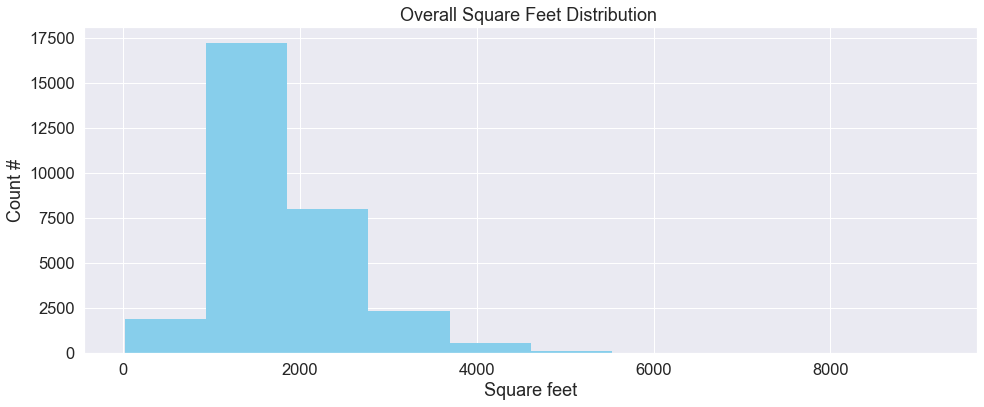

In [38]:
# Plot Square feet distribution
plt.figure(figsize = (16, 6))
plt.title('Overall Square Feet Distribution ')
plt.ylabel('Count #')
plt.xlabel('Square feet')
train.finished_sq_feet.hist(color = "skyblue", lw=0)
plt.show()

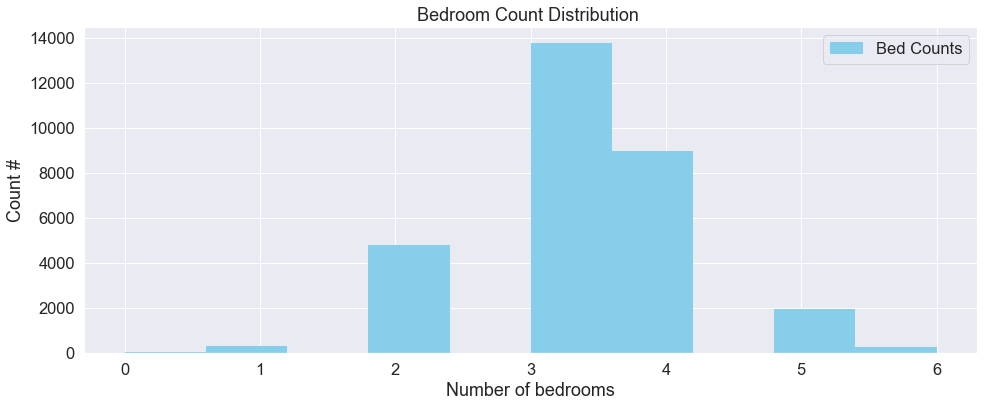

In [39]:
# Plot bedroom count distribution
plt.figure(figsize = (16, 6))
plt.title('Bedroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bedrooms')
train.bedroom_count.hist(color = "skyblue", lw=0, label = 'Bed Counts')
plt.legend()
plt.show()

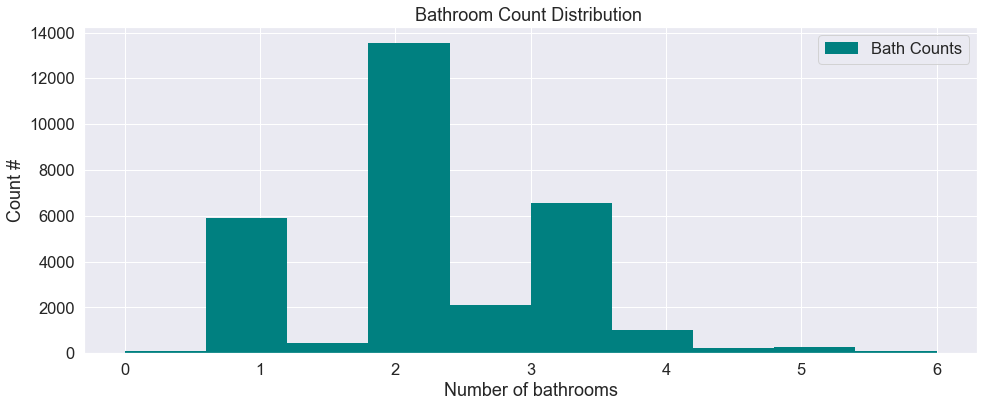

In [40]:
# Plot bathroom count distribution
plt.figure(figsize = (16, 6))
plt.title('Bathroom Count Distribution ')
plt.ylabel('Count #')
plt.xlabel('Number of bathrooms')
train.bath_count.hist(color = "teal", lw=0, label = 'Bath Counts')
plt.legend()
plt.show()

#### Takeaways
- 3 bedrooms and 2 bathrooms are the most common household classification in 2017

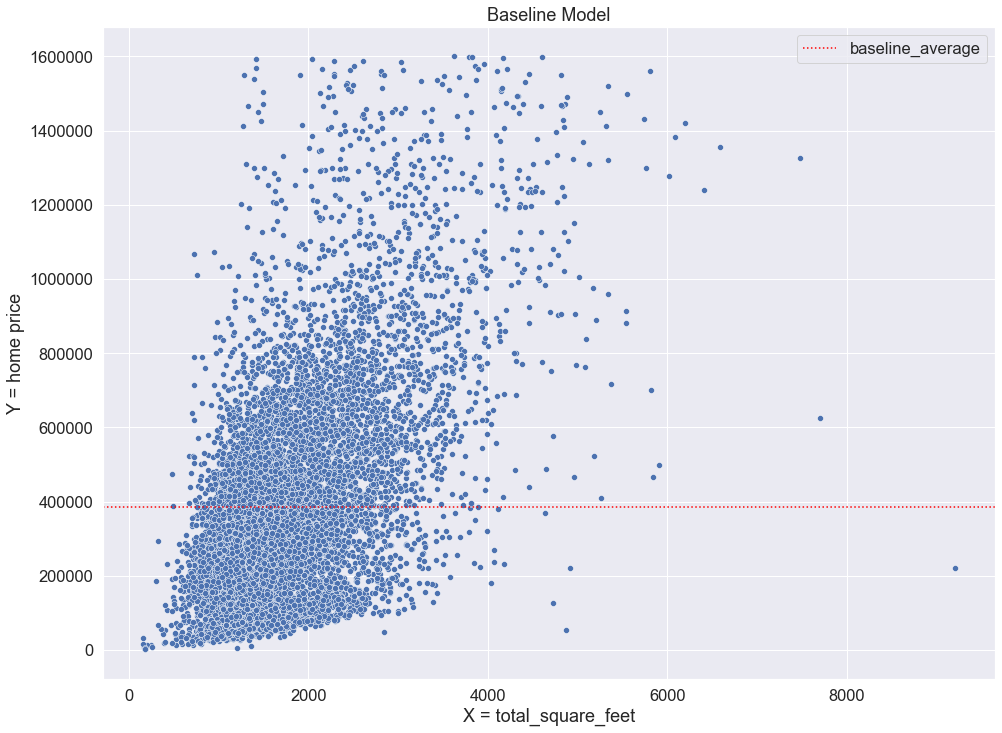

In [9]:
# Time to plot the mean baseline prediction against actual targets

plt.figure(figsize = (16,12))
sns.set(font_scale = 1.5)

sns.scatterplot(x = "finished_sq_feet", y = "home_value", data = train.sample(10000), x_jitter = 0.5)
plt.ticklabel_format(style = "plain") 

plt.axhline(baseline_predictions, ls = ':', color = "red", label = "baseline_average")
plt.xlabel('X = total_square_feet')
plt.ylabel('Y = home price')

plt.legend()
plt.title('Baseline Model')
plt.show()

### Create and fit a new home_value prediction model

In [10]:
from sklearn.linear_model import LinearRegression

# creating the independent and dependent variables
X_var = pd.DataFrame(train.finished_sq_feet)
y_var = pd.DataFrame(train.home_value)

In [11]:
# creating the model

model = LinearRegression(normalize = True)
model.fit(X_var, y_var)
predictions = model.predict(X_var)

In [12]:
# let's create a dataframe with all four (4) features:
# home_value (dependent variable)
# finished_sq_feet (independent variable)
# predicted avg. baseline home value
# created model predictions

df = pd.concat([X_var, y_var], axis = 1)
model_df = df.copy().reset_index(drop = True)

model_df["baseline"] = baseline_predictions

In [13]:
# including the "y_hat"/home value predictions
model_df["predictions"] = predictions.round(2)
model_df.head()

,finished_sq_feet,home_value,baseline,predictions
0,2024.0,197490.0,385876.79,436987.40
1,1350.0,283846.0,385876.79,292243.25
2,2239.0,214953.0,385876.79,483159.49
3,1397.0,193010.0,385876.79,302336.69
4,706.0,338469.0,385876.79,153941.72


### Plot residuals for the linear regression model that you made

In [14]:
# plotting the baseline residual error (actual - baseline prediction)
model_df["baseline_residuals"] = model_df["home_value"] - model_df["baseline"]
model_df.head()

,finished_sq_feet,home_value,baseline,predictions,baseline_residuals
0,2024.0,197490.0,385876.79,436987.40,-188386.79
1,1350.0,283846.0,385876.79,292243.25,-102030.79
2,2239.0,214953.0,385876.79,483159.49,-170923.79
3,1397.0,193010.0,385876.79,302336.69,-192866.79
4,706.0,338469.0,385876.79,153941.72,-47407.79


In [15]:
model_df["residuals"] = model_df["home_value"] - model_df["predictions"]
model_df.head()

,finished_sq_feet,home_value,baseline,predictions,baseline_residuals,residuals
0,2024.0,197490.0,385876.79,436987.40,-188386.79,-239497.40
1,1350.0,283846.0,385876.79,292243.25,-102030.79,-8397.25
2,2239.0,214953.0,385876.79,483159.49,-170923.79,-268206.49
3,1397.0,193010.0,385876.79,302336.69,-192866.79,-109326.69
4,706.0,338469.0,385876.79,153941.72,-47407.79,184527.28


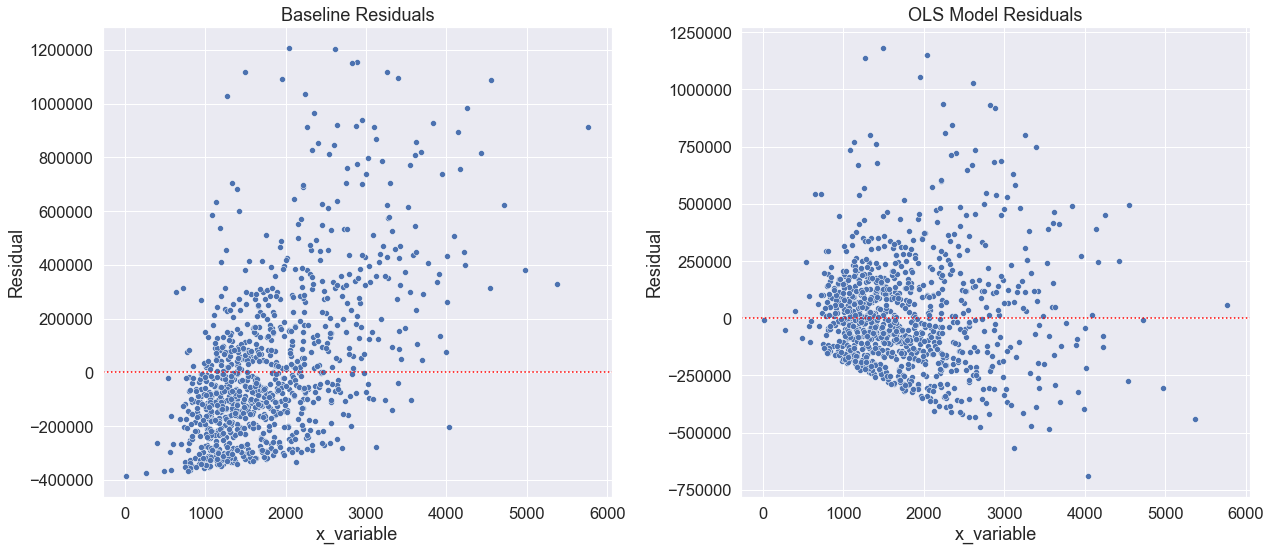

In [16]:
# considering creating a function that creates these plots

plt.figure(figsize = (12,6))

plt.subplot(121)
ax = sns.scatterplot(x = "finished_sq_feet", y = "baseline_residuals", data = model_df.sample(1000, random_state = 123))
plt.axhline(y = 0, ls = ':', color = "red")
plt.xlabel('x_variable')
plt.ylabel('Residual')
plt.title('Baseline Residuals')
 # removing axes scientific notation
plt.ticklabel_format(style = "plain")

# making individual plots more readable
ax.figure.set_size_inches(18, 6)

plt.subplot(122)
ax = sns.scatterplot(x = "finished_sq_feet", y = "residuals", data = model_df.sample(1000, random_state = 123))
plt.axhline(y = 0, ls = ':', color = "red")

plt.xlabel('x_variable')
plt.ylabel('Residual')
plt.title('OLS Model Residuals')
# removing axes scientific notation
plt.ticklabel_format(style = "plain") 

# making individual plots more readable
ax.figure.set_size_inches(18, 8)
plt.tight_layout()

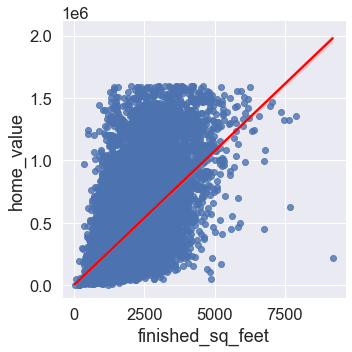

In [56]:
#sns.relplot(x="finished_sq_feet", y="home_value", data=train)
#plt.show()


# I can really pop that line color if I want.

sns.lmplot(x="finished_sq_feet", y="home_value", data=train, line_kws={'color': 'red'})
plt.show()

### Takeaways
- My lmplot chart shows me that there is a linear relationship between finished_sq_feet and home_value.

#### Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.

In [17]:
# calculating the Sum of Squared Errors "SSE" or "Residual Sum of Squares"/RSS for my model
# where the Sum of Squared Errors or Residual Sum of Squares refers to the total "dispersion" of the individual data point error
# this measurement can determine how well or not the created model represents the "actual" target data

model_df["residual^2"] = model_df["residuals"].round(2) ** 2
model_df["baseline_residual^2"] = model_df["baseline_residuals"].round(2) ** 2
model_df.head()

,finished_sq_feet,home_value,baseline,predictions,baseline_residuals,residuals,residual^2,baseline_residual^2
0,2024.0,197490.0,385876.79,436987.40,-188386.79,-239497.40,5.735900e+10,3.548958e+10
1,1350.0,283846.0,385876.79,292243.25,-102030.79,-8397.25,7.051381e+07,1.041028e+10
2,2239.0,214953.0,385876.79,483159.49,-170923.79,-268206.49,7.193472e+10,2.921494e+10
3,1397.0,193010.0,385876.79,302336.69,-192866.79,-109326.69,1.195233e+10,3.719760e+10
4,706.0,338469.0,385876.79,153941.72,-47407.79,184527.28,3.405032e+10,2.247499e+09


In [18]:
# calculating sum of squared error

SSE_model = sum(model_df["residual^2"])
print('(Model) SSE = {:.1f}'.format(SSE_model))

(Model) SSE = 1619228303958122.0


In [19]:
# calculating the explained sum of squares or "ESS"
# explained error
# The ESS (Explained Sum of Squares) is the sum of the difference between each predicted value (y_hat = home_price prediction) and the mean of all actual values (y.mean = home_value mean)

ESS_model = sum((model_df["predictions"] - model_df["home_value"].mean()) ** 2)
print('(Model) Explained Sum of Squares = {:.1f}'.format(ESS_model))

(Model) Explained Sum of Squares = 803779830410619.4


In [20]:
# calculating the total sum of squares errors or "TSS"
# The TSS (Total Sum of Squares) is the sum of difference between the actual final grade and the mean of all final grades
# It can also be derived by summing the ESS and SSE

TSS_model = ESS_model + SSE_model
print('(Model) Total Sum of Squares = {:.1f}'.format(TSS_model))

(Model) Total Sum of Squares = 2423008134368741.5


In [21]:
# calculating mean squared error or MSE
# we arrive at this by dividing your SSE by the total number of data points
# i.e. the average of your errors that have each been squared

MSE_model = SSE_model/len(model_df)
print('(Model) Mean Squared Error = {:.1f}'.format(MSE_model))

(Model) Mean Squared Error = 53499910921.8


In [23]:
# calculating the root mean squared error or RMSE

RMSE_model = sqrt(MSE_model)
print('(Model) Root Mean Squared Error = {:.1f}'.format(RMSE_model))

(Model) Root Mean Squared Error = 231300.5


#### Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount / or "baseline_predictions).

In [26]:
# calculating sum of squared error

SSE_baseline = sum(model_df["baseline_residual^2"])
print('(Baseline) SSE = {:.1f}'.format(SSE_baseline))

(Baseline) SSE = 2423008134263512.5


In [27]:
# calculating the explained sum of squares or "ESS"
# explained error
# The ESS (Explained Sum of Squares) is the sum of the difference between each predicted value (y_hat = home_price prediction) and the mean of all actual values (y.mean = home_value mean)

ESS_baseline = sum((model_df["baseline"] - model_df["home_value"].mean()) ** 2)
print('(Baseline) Explained Sum of Squares = {:.1f}'.format(ESS_baseline))

(Baseline) Explained Sum of Squares = 0.6


In [28]:
# calculating the total sum of squares errors or "TSS"
# The TSS (Total Sum of Squares) is the sum of difference between the actual final grade and the mean of all final grades
# It can also be derived by summing the ESS and SSE

TSS_baseline = ESS_baseline + SSE_baseline
print('(Baseline) Total Sum of Squares = {:.1f}'.format(TSS_baseline))

(Baseline) Total Sum of Squares = 2423008134263513.0


In [29]:
# calculating mean squared error or MSE
# we arrive at this by dividing your SSE by the total number of data points
# i.e. the average of your errors that have each been squared

MSE_baseline = SSE_baseline/len(model_df)
print('(Baseline) Mean Squared Error = {:.1f}'.format(MSE_baseline))

(Baseline) Mean Squared Error = 80057098204.7


In [30]:
# calculating the root mean squared error or RMSE

RMSE_baseline = sqrt(MSE_baseline)
print('(Baseline) Root Mean Squared Error = {:.1f}'.format(RMSE_baseline))

(Baseline) Root Mean Squared Error = 282943.6


#### Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.

In [31]:
def compare_sum_of_squares(SSE_baseline, SSE_model):
    if SSE_model >= SSE_baseline:
        print("Model ain't cutting it")
    else:
        print("Model outperforms baseline!")

#### What is the amount of variance explained in your model?

In [32]:
# calculating model variance
# where variance == R^2 or "coefficient of determination" (a measurement from 0 to 1)
# R2: variance in y (target) explained by X (predictor); closer to 1 is better

model_variance = ESS_model/TSS_model
print('Model Variance = {:.1f}'.format(model_variance))

Model Variance = 0.3


In [33]:

# calculating the baseline variance

baseline_variance = ESS_baseline/TSS_baseline
print('Baseline Variance = {:.1f}'.format(baseline_variance))

Baseline Variance = 0.0


In [35]:
# let's use sklearn to calculate model variance

model_var = sklearn.metrics.explained_variance_score(model_df["home_value"], model_df["predictions"])
model_var.round(3)

0.332

In [36]:
# let's use sklearn to calculate baseline variance

baseline_var = sklearn.metrics.explained_variance_score(model_df["home_value"], model_df["baseline"])
baseline_var.round(3) 

0.0

#### This model performs 33% better than baseline